In [53]:
import random
import imageio
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

Descarga del conjunto de datos **MNIST** original

* Tamaño: (N, 28, 28, 1), donde N es el número de muestras de la submuestra.
* Valores de intensidad: float32 en el rango [0, 1].

In [54]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

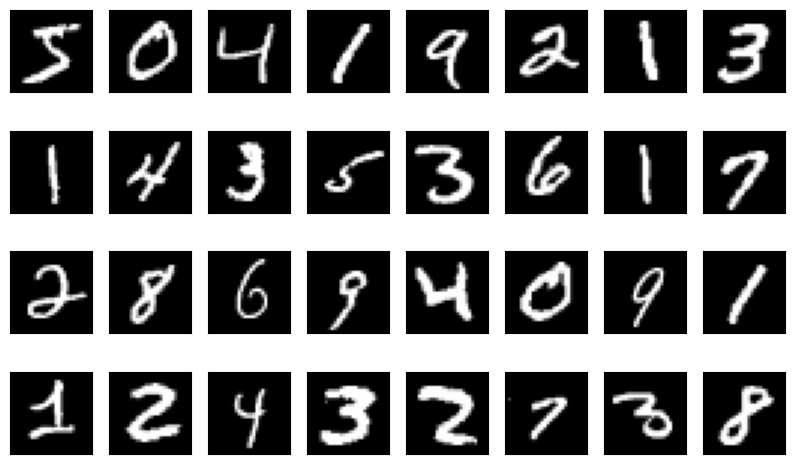

In [55]:
def plot_some_samples(some_samples):
    fig = plt.figure(figsize=(10, 6))
    for j in range(some_samples.shape[0]):
        ax = fig.add_subplot(4, 8, j+1)
        ax.imshow(some_samples[j,:,:,0], cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_some_samples(train_x[:32, ...])

### Combinar el conjunto de datos MNSIT original y los dos nuevos conjuntos de datos generados.
Obtenga los conjuntos de datos finales de entrenamiento y prueba que contienen los datos originales y los nuevos datos generados (concaténelo todo por dimensión cero).

In [56]:
train_x = np.concatenate((train_x, bg_train_x, sh_train_x), axis=0)
train_y = np.concatenate((train_y, bg_train_y, sh_train_y), axis=0)

### Entrenamiento del clasificador

In [57]:
NUM_CLASSES = 11
NUM_EPOCHS = 3
BATCH_SIZE = 64

**Modelo de clasificación**
Este es nuestro clasificador basado en CNN. Hay 11 clases en la salida.

In [58]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

In [59]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [60]:
model.fit(train_x, train_y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/3
3282/3282 [==============================] - 102s 31ms/step - loss: 0.1193 - accuracy: 0.9638
Epoch 2/3
3282/3282 [==============================] - 95s 29ms/step - loss: 0.0415 - accuracy: 0.9866
Epoch 3/3
3282/3282 [==============================] - 95s 29ms/step - loss: 0.0294 - accuracy: 0.9901


In [61]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 2s 5ms/step - loss: 0.0260 - accuracy: 0.9917


[0.026001157239079475, 0.9916999936103821]

# Localización débil usando una ventana deslizante

En primer lugar, generemos una imagen de prueba para el problema de localización y, a continuación, apliquémosle el método de la ventana deslizante (construyamos mapas de calor).

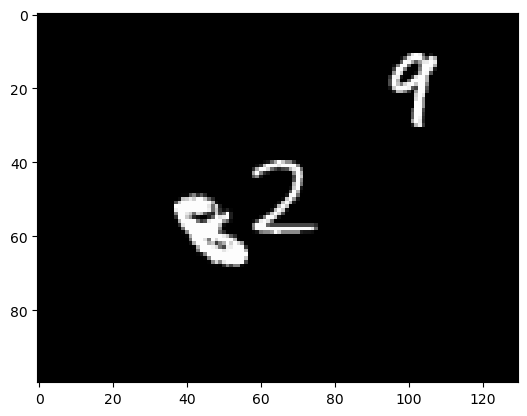

In [62]:
if True: # Generar una imagen aleatoria
    
    img = np.zeros((100, 130, 1), dtype=np.float32)
    def add_digit(img, digit):
        ofs = (random.randint(0, img.shape[0]-digit.shape[0]),
               random.randint(0, img.shape[1]-digit.shape[1]))
        img[ofs[0]:ofs[0]+digit.shape[0], ofs[1]:ofs[1]+digit.shape[1], :] += digit
        img = np.clip(img, 0.0, 1.0)
        return img
    for _ in range(3):
        digit = test_x[random.randint(0, test_x.shape[0])]
        img = add_digit(img, digit)
    
else: # Cargar la imagen terminada 'digits.png'
    
    INPUT_IMAGE_FPTAH = 'digits.png'
    img = imageio.imread(INPUT_IMAGE_FPTAH, pilmode="RGB")
    img = img.astype(np.float32)/255.
    img = np.mean(img, axis=2, keepdims=True)
    
# Convertir la imagen de entrada a RGB 
# (para su visualización y posterior mezcla con un mapa térmico de color)
img_clr = np.tile(img, (1, 1, 3))
_=plt.imshow(img_clr)

### Preparando el buffer para los mapas de calor

El buffer de mapas de calor será un tensor tridimensional. Las dos primeras dimensiones son espaciales, la tercera dimensión es responsable de las clases, de las cuales tenemos 11.

In [63]:
inp_shape = (train_x.shape[1], train_x.shape[2]) # tamaño de entrada para el clasificador

heatmaps = np.zeros((            # Inicializando el tensor del mapa de calor
    img.shape[0] - inp_shape[0] + 1,
    img.shape[1] - inp_shape[1] + 1,
    NUM_CLASSES))

In [64]:
window = img[0:inp_shape[0], 0:inp_shape[1], :]
pred = model.predict(window[None, ...])[0, ...]
heatmaps[0, 0, :] = pred

1/1 [==============================] - 0s 103ms/step


In [65]:
for i in range(heatmaps.shape[0]):
    for j in range(heatmaps.shape[1]):
        window = img[i:i+inp_shape[0], j:j+inp_shape[1], :]
        heatmaps[i,j,:] = model.predict(window[None, ...])[0, ...]


1/1 [==============================] - 0s 24ms/step


In [66]:
diff = (img.shape[0]-heatmaps.shape[0],
        img.shape[1]-heatmaps.shape[1],)

heatmaps = np.pad(heatmaps, (
    (diff[0]//2,diff[0]-diff[0]//2),
    (diff[1]//2,diff[1]-diff[1]//2),
    (0, 0)
), 'constant')

Heatmap for class: 0


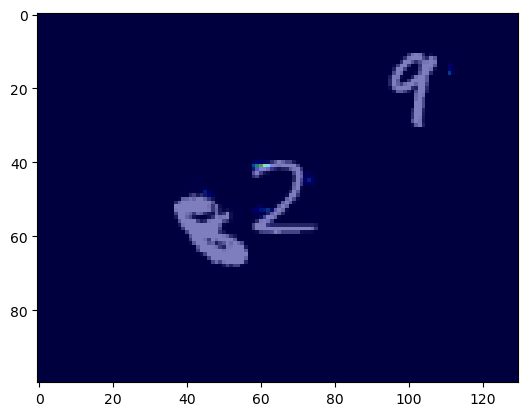

Heatmap for class: 1


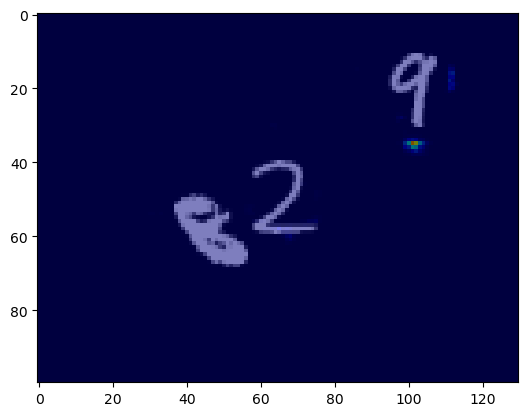

Heatmap for class: 2


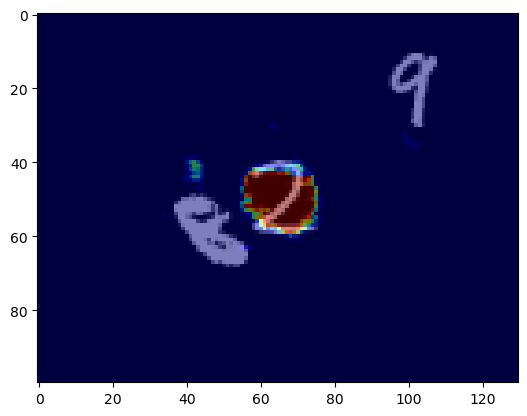

Heatmap for class: 3


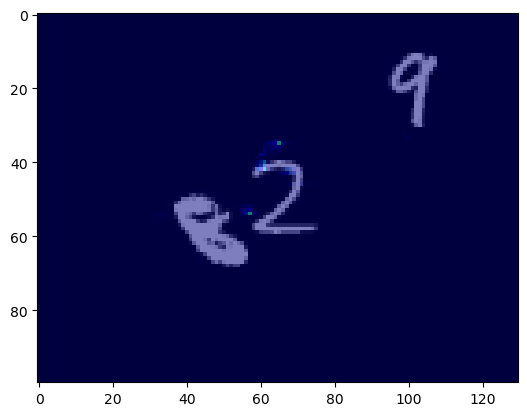

Heatmap for class: 4


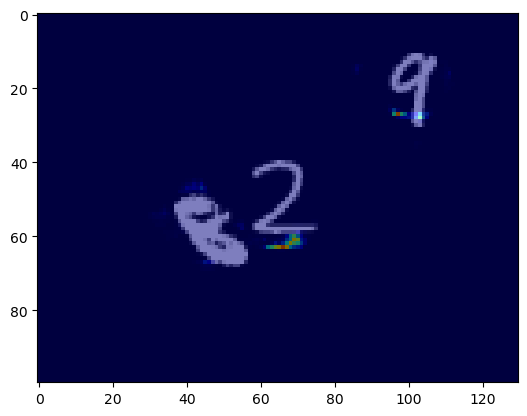

Heatmap for class: 5


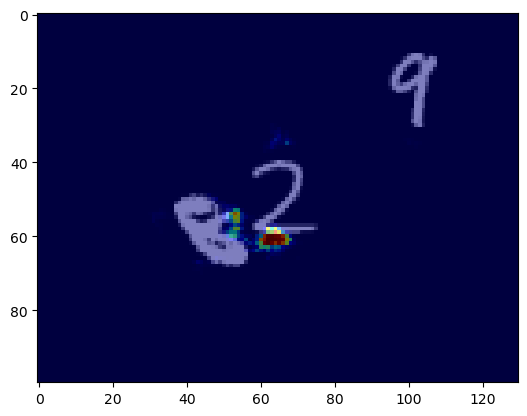

Heatmap for class: 6


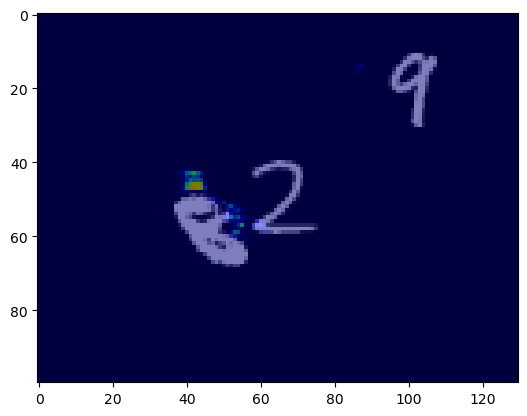

Heatmap for class: 7


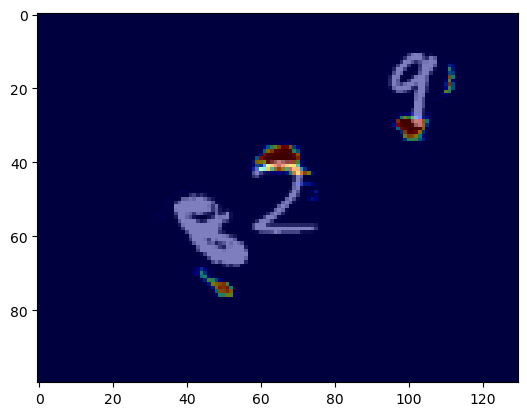

Heatmap for class: 8


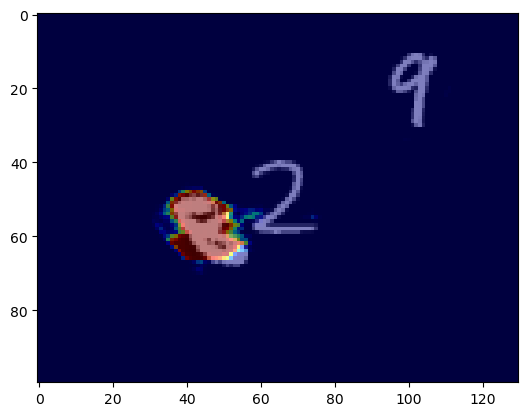

Heatmap for class: 9


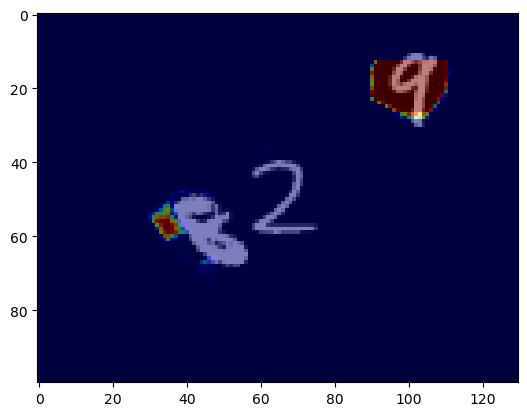

Heatmap for class: 10


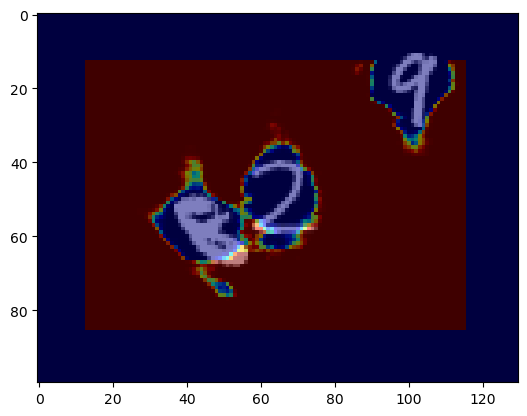

In [67]:
for clss in range(11):
    heatmap = heatmaps[..., clss]
    heatmap_clr = plt.get_cmap('jet')(heatmap)[..., :3]
    print('Heatmap for class:', clss)
    plt.imshow(img_clr*0.5 + heatmap_clr*0.5)    
    plt.show()